IMPORTING DEPENDENCIES

In [28]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten
from keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D

Link to the Original Dataset:  [HERE](https://www.kaggle.com/datasets/ahmedhamada0/brain-tumor-detection/data)

DATA LOADING / DATA ACQUISITION

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
path = '/content/gdrive/MyDrive/Brain_Tumor_Dataset'

ds = keras.utils.image_dataset_from_directory (
    directory = path,
    labels = 'inferred',
    label_mode = 'int',
    batch_size = 32,
    image_size = (150, 150),
    shuffle = True,
)

Found 3000 files belonging to 2 classes.


TRAIN-TEST SPLITTING

In [4]:
DATASET_SIZE =len(ds)

train_ratio, test_ratio = 0.8, 0.2

train = ds.take(int(DATASET_SIZE * train_ratio))
test  = ds.skip(int(DATASET_SIZE * train_ratio))

val = ds.take (int(len(test) * 0.5))

print(len(train), len(test))

75 19


DATA SAMPLE VISUALIZATION

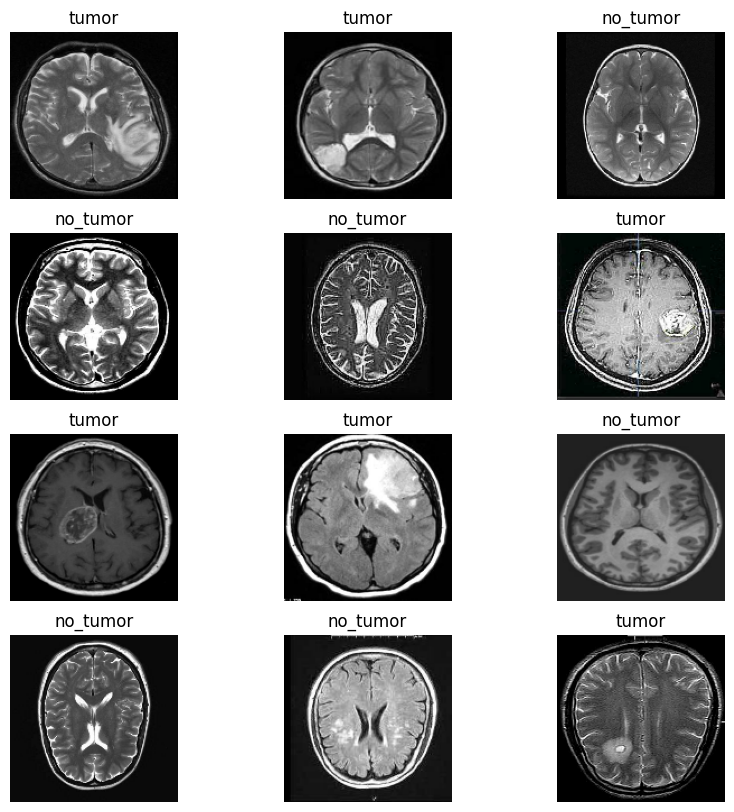

In [5]:
classes = ds.class_names

plt.figure (figsize = (10,10))

for image_batch, label_batch in ds.take(1):
    for i in range(12):
        axes = plt.subplot(4,3,i+1)
        plt.imshow (image_batch[i].numpy().astype('uint8'))
        plt.title (classes[label_batch[i]])
        plt.axis('off')

AUGMENTATION

In [6]:
def augmentation (image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_crop(image, size= [32, 150, 150, 3])
    return image, label

new_train = train.map(augmentation)

def Scaler (image, label):
    image= tf.cast(image/255. , tf.float32)
    return image, label

new_train, new_test, new_val = new_train.map(Scaler), test.map(Scaler), val.map(Scaler)

MODEL BUILDING

In [7]:
model = Sequential([
    Conv2D(32, kernel_size= (3,3), activation= 'relu', padding= 'same', input_shape=(150, 150, 3)),
    MaxPooling2D(pool_size= (2,2)),
    Dropout(0.25),
    Conv2D(32, kernel_size= (3,3), activation= 'relu', padding= 'same'),
    MaxPooling2D(pool_size= (2,2)),
    Dropout(0.25),
    Conv2D(32, kernel_size= (3,3), activation= 'relu', padding= 'same'),
    MaxPooling2D(pool_size= (2,2)),
    Dropout(0.25),
    Conv2D(32, kernel_size= (3,3), activation= 'relu', padding= 'same'),
    MaxPooling2D(pool_size= (2,2)),
    Dropout(0.25),
    Conv2D(32, kernel_size= (3,3), activation= 'relu', padding= 'same'),
    MaxPooling2D(pool_size= (2,2)),
    Dropout(0.25),
    Conv2D(32, kernel_size= (3,3), activation= 'relu', padding= 'same'),
    MaxPooling2D(pool_size= (2,2)),
    Flatten(),
    Dense(64, activation = 'relu'),
    Dropout(0.5),
])

# Adding SVM Layer
model.add(
    Dense(1, kernel_regularizer=tf.keras.regularizers.l2(0.01), activation= 'linear')
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 75, 75, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 75, 75, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 37, 37, 32)        0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 37, 37, 32)        0

In [8]:
model.compile (
    optimizer ='adam',
    loss ='hinge',
    metrics = ['accuracy']
)

In [9]:
early_stopping = EarlyStopping (
    monitor = 'loss',
    patience = 3,
    restore_best_weights =True,
)

MODEL TRAINING

In [10]:
history= model.fit (
    new_train,
    epochs =25,
    validation_data = new_val,
    batch_size= 32,
    verbose= 1,
    callbacks = [early_stopping]
)

Epoch 1/25
75/75 [==============================] - 295s 4s/step - loss: 0.9779 - accuracy: 0.5396 - val_loss: 0.8445 - val_accuracy: 0.6007
Epoch 2/25
75/75 [==============================] - 12s 144ms/step - loss: 0.6983 - accuracy: 0.6787 - val_loss: 0.7400 - val_accuracy: 0.5729
Epoch 3/25
75/75 [==============================] - 11s 143ms/step - loss: 0.6035 - accuracy: 0.7304 - val_loss: 0.5539 - val_accuracy: 0.7153
Epoch 4/25
75/75 [==============================] - 11s 136ms/step - loss: 0.5519 - accuracy: 0.7471 - val_loss: 0.4615 - val_accuracy: 0.7743
Epoch 5/25
75/75 [==============================] - 11s 128ms/step - loss: 0.5002 - accuracy: 0.7763 - val_loss: 0.4578 - val_accuracy: 0.7674
Epoch 6/25
75/75 [==============================] - 13s 158ms/step - loss: 0.4872 - accuracy: 0.7792 - val_loss: 0.4872 - val_accuracy: 0.7535
Epoch 7/25
75/75 [==============================] - 13s 158ms/step - loss: 0.4440 - accuracy: 0.7983 - val_loss: 0.4625 - val_accuracy: 0.7743
E

In [11]:
model.save ('model_svm.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


MODEL EVALUATION ON TEST DATASET

In [12]:
loss, accuracy = model.evaluate(new_test)

print(loss, accuracy)

19/19 [==============================] - 47s 2s/step - loss: 0.0868 - accuracy: 0.9517
0.08678324520587921 0.9516666531562805


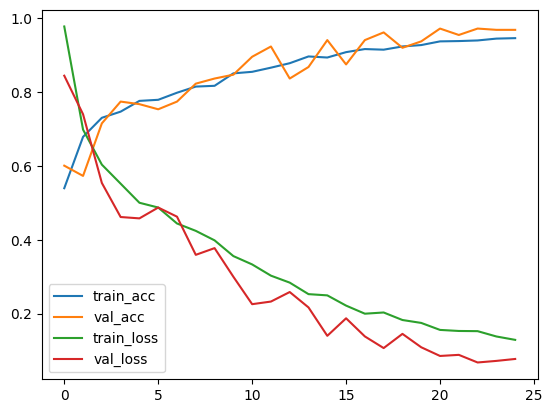

In [13]:
plt.plot (history.history['accuracy'])
plt.plot (history.history['val_accuracy'])

plt.plot (history.history['loss'])
plt.plot (history.history['val_loss'])

plt.legend(['train_acc', 'val_acc', 'train_loss', 'val_loss'])

CONFUSION MATRIX & CLASSFICATION REPORT

In [18]:
true_labels, pred_labels = [], []

for images, labels in new_test:
    true_labels.extend(labels.numpy())
    pred = model.predict(images)
    for p in pred:
        res = 0 if p < 0 else 1
        pred_labels.append(res)

true, predicted = np.array(true_labels), np.array(pred_labels)

1/1 [==============================] - 0s 21ms/step


<Axes: >

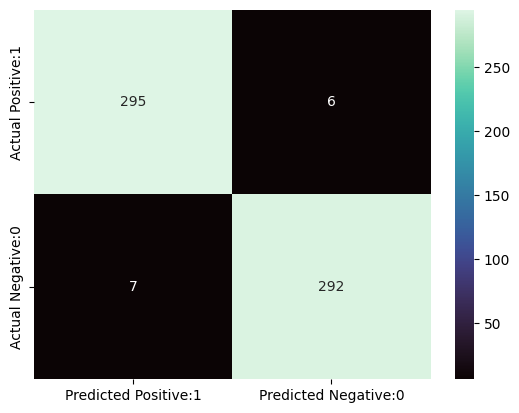

In [23]:
cm = confusion_matrix(true, predicted)
cm_matrix = pd.DataFrame(data=cm, columns=['Predicted Positive:1', 'Predicted Negative:0'], index=['Actual Positive:1', 'Actual Negative:0'])

sns.heatmap(cm_matrix, annot=True, fmt = 'd', cmap='mako')

In [22]:
report = classification_report(true, predicted)

print(report)

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       301
           1       0.98      0.98      0.98       299

    accuracy                           0.98       600
   macro avg       0.98      0.98      0.98       600
weighted avg       0.98      0.98      0.98       600



3D VISUALIZATION OF THE ACHIEVED RESULTS

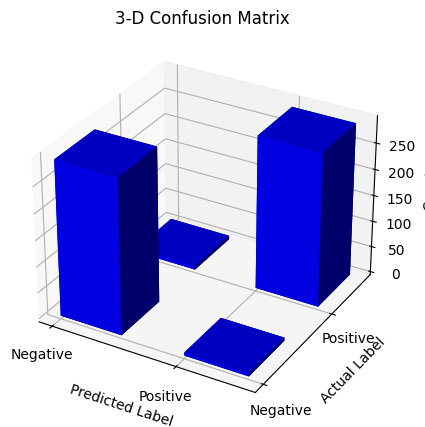

In [30]:
confusion_matrix = np.array(cm)

x_coords, y_coords = np.meshgrid(np.arange(confusion_matrix.shape[0]), np.arange(confusion_matrix.shape[1]))
x_coords, y_coords = x_coords.flatten(), y_coords.flatten()
z_coords = np.zeros_like(x_coords)

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, projection='3d')

ax.bar3d(x_coords, y_coords, z_coords, dx=0.5, dy=0.5, dz=confusion_matrix.flatten(), color='b')

ax.set_xlabel('Predicted Label')
ax.set_ylabel('Actual Label')
ax.set_zlabel('Count')
ax.set_title('3-D Confusion Matrix')

ax.set_xticks(np.arange(confusion_matrix.shape[0]))
ax.set_yticks(np.arange(confusion_matrix.shape[1]))
ax.set_xticklabels(['Negative', 'Positive'])
ax.set_yticklabels(['Negative', 'Positive'])

plt.show()